# Rossby Wave Packet Diagnostics (Ghinassi et al. 2018)

A reproduction of the results of section 4, Large-amplitude Rossby wave packets in an idealized barotropic model simulation, by [Ghinassi et al. (2018)](https://doi.org/10.1175/MWR-D-18-0068.1).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import barotropic as bt

## Model setup and integration

In [2]:
# 2° resolution of longitude-latitude grid
grid = bt.Grid(resolution=2.)
# No forcing
rhs = None
# Model with hyperdiffusion
model = bt.BarotropicModel(rhs, diffusion_order=2, diffusion_coeff=1.0e15)

In [3]:
# Start from Held and Phillips (1987) zonal profile
background_u = bt.init.held_1985(grid)

# Add perturbation according to eqs. (24) to (26)
# λ_2 = 3π/2 here instead of 2π/3 as in the paper, which seems to be a typo
def perturbation_vorticity(grid, s1, s2, zeta0, phi0, lam1, lam2, sigma_phi, sigma_lam):
    L1 = np.exp(-((grid.lam2 - lam1)/sigma_lam)**2) * np.sin(s1 * grid.lam2)
    L2 = np.exp(-((grid.lam2 - lam2)/sigma_lam)**2) * np.cos(s2 * grid.lam2)
    return zeta0 * np.cos(grid.phi2) * np.exp(-((grid.phi2 - phi0)/sigma_phi)**2) * (L1 + L2)

perturbation = perturbation_vorticity(grid, s1=6, s2=9, zeta0=8.0e-5, phi0=np.pi/4,
        lam1=np.pi/3, lam2=3*np.pi/2, sigma_phi=np.deg2rad(10), sigma_lam=np.deg2rad(30))

# Add vorticity perturbation to background state to obtain initial state
init = background_u.add_vorticity(perturbation)

# Run model for 5 days with a timestep of 900 seconds and save state every 24 hours
last, states = model.run(init, 900, 5*bt.DAY, save_every=1*bt.DAY)

## Figure 5

Absolute vorticity in the barotropic model simulation (a) at initial time and (b) after 5 days of integration.

In [4]:
def style_lonlat(ax):
    ax.set_xticks([0, 60, 120, 180, 240, 300])
    ax.set_xticklabels(["0°", "60°E", "120°E", "180°", "120°W", "60°W"])
    ax.set_ylim([0, 90])
    ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
    ax.set_yticklabels(["0°", "10°N", "20°N", "30°N", "40°N", "50°N", "60°N", "70°N", "80°N"])
    ax.grid(linestyle="dotted", color="k")

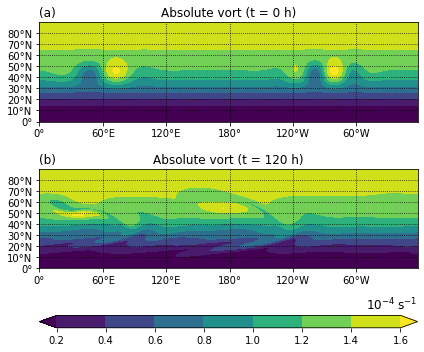

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 5), gridspec_kw=dict(height_ratios=(8, 8, 1)))

pv_levels = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6]
pv_cmap = "viridis"

ax1.set_title("(a)", loc="left")
ax1.set_title("Absolute vort (t = {:.0f} h)".format(init.time / bt.HOUR), loc="center")
ax1.contourf(grid.lon2, grid.lat2, init.pv * 10000,
             levels=pv_levels, cmap=pv_cmap, extend="both")
style_lonlat(ax1)

ax2.set_title("(b)", loc="left")
ax2.set_title("Absolute vort (t = {:.0f} h)".format(last.time / bt.HOUR), loc="center")
pv2 = ax2.contourf(grid.lon2, grid.lat2, last.pv * 10000,
                   levels=pv_levels, cmap=pv_cmap, extend="both")
plt.colorbar(pv2, cax=ax3, orientation="horizontal")
ax3.set_title("$10^{-4}\;\mathrm{s}^{-1}$", loc="right")
style_lonlat(ax2)

fig.tight_layout()

## Figure 6

Evolution of (left) filtered LWA and (right) the envelope of the meridional wind in the barotropic model simulation, shown as snapshots every 24h.

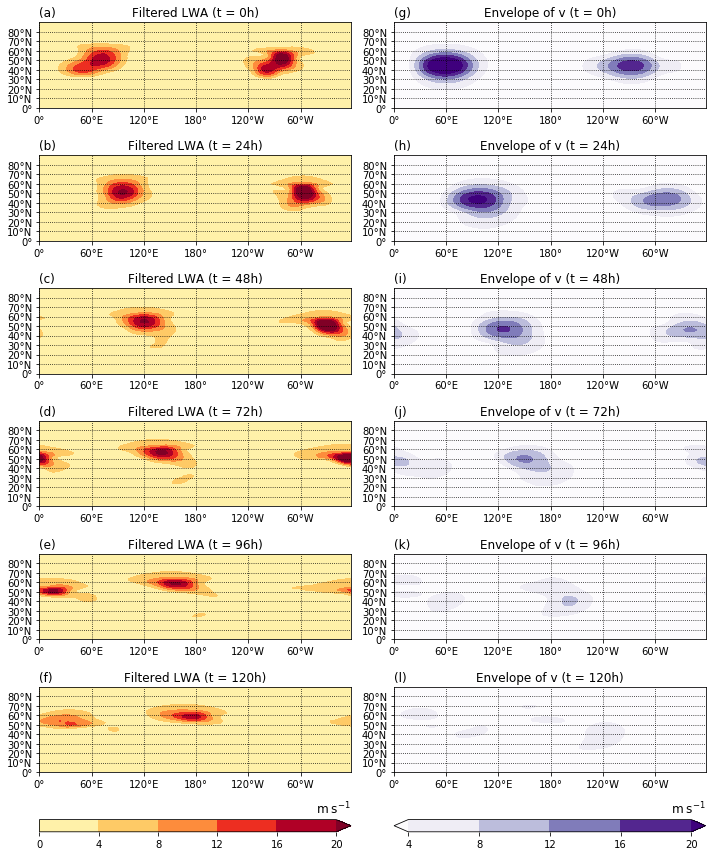

In [6]:
fig, axs = plt.subplots(7, 2, figsize=(10, 12), gridspec_kw=dict(height_ratios=(7, 7, 7, 7, 7, 7, 1)))

panels = list("lfkejdichbga")

for state, (axl, axr) in zip(states, axs):
    # State.falwa_filtered uses Fourier instead of wavelet transform to
    # obtain the dominant wavenumber, so compute manually here
    dominant_wavenumber = bt.diagnostics.dominant_wavenumber_wavelet(state.v, grid)
    falwa_filtered = bt.diagnostics.filter_by_wavenumber(state.falwa, 2*dominant_wavenumber)

    axl.set_title("(" + panels.pop() + ")", loc="left")
    axl.set_title("Filtered LWA (t = {:.0f}h)".format(state.time / bt.HOUR), loc="center")
    ml = axl.contourf(grid.lon2, grid.lat2, falwa_filtered,
                      levels=[0, 4, 8, 12, 16, 20], extend="max", cmap="YlOrRd")
    axr.set_title("(" + panels.pop() + ")", loc="left")
    axr.set_title("Envelope of v (t = {:.0f}h)".format(state.time / bt.HOUR), loc="center")
    mr = axr.contourf(grid.lon2, grid.lat2, state.v_envelope_hilbert,
                      levels=[4, 8, 12, 16, 20], extend="both", cmap="Purples")

plt.colorbar(ml, cax=axs[-1,0], orientation="horizontal")
plt.colorbar(mr, cax=axs[-1,1], orientation="horizontal")

axs[-1,0].set_title("$\mathrm{m}\;\mathrm{s}^{-1}$", loc="right")
axs[-1,1].set_title("$\mathrm{m}\;\mathrm{s}^{-1}$", loc="right")

for ax in axs[:-1,:].flatten():
    style_lonlat(ax)

fig.tight_layout()

## Figure A1

Initial state of the barotropic model simulation: (a) meridional wind $v$ and (b) local dominant wavenumber from wavelet analysis.

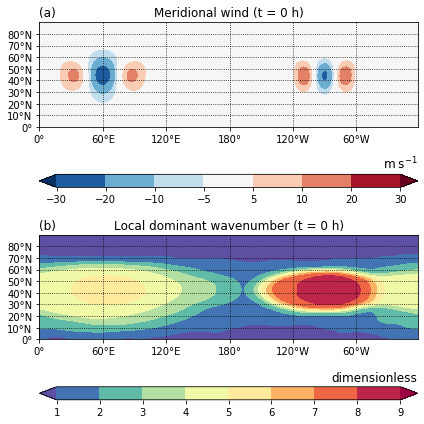

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(6, 6), gridspec_kw=dict(height_ratios=(8, 1, 8, 1)))

ax1.set_title("(a)", loc="left")
ax1.set_title("Meridional wind (t = {:.0f} h)".format(init.time / bt.HOUR), loc="center")
m1 = ax1.contourf(grid.lon2, grid.lat2, init.v,
                  levels=[-30, -20, -10, -5, 5, 10, 20, 30], cmap="RdBu_r", extend="both")
plt.colorbar(m1, cax=ax2, orientation="horizontal")
ax2.set_title("$\mathrm{m}\;\mathrm{s}^{-1}$", loc="right")
style_lonlat(ax1)

ax3.set_title("(b)", loc="left")
ax3.set_title("Local dominant wavenumber (t = {:.0f} h)".format(init.time / bt.HOUR), loc="center")
m3 = ax3.contourf(grid.lon2, grid.lat2, bt.diagnostics.dominant_wavenumber_wavelet(init.v, grid),
                  levels=[1, 2, 3, 4, 5, 6, 7, 8, 9], cmap="Spectral_r", extend="both")
plt.colorbar(m3, cax=ax4, orientation="horizontal")
ax4.set_title("dimensionless", loc="right")
style_lonlat(ax3)

fig.tight_layout()